In [2]:
"""
Download NAIP imagery from NOAA

Find the tif URL from NOAA tile index shapefiles. For each plot, we will find the tile 
that intersects the plot bbox in the tile index shp. Since there are two shapefiles, 
one for OR and one for WA, we will import and concaternate them into a single geodataframe. 

The steps are:
1. Import the tile index shapefiles as geodataframes
2. Concaternate both geodataframes
3. Import the plot data
4. Iterate over the plots and 
  a. find the tile that intersects with plot bbox. Different plots can inteserct the same tile.
  b. retrieve the url of the tif file
  c. retrieve the name of the tile
  d. open tif url with rasterio

NOAA seems to have NAIP data only for 2021 (WA), 2020 (OR), 2016 (OR), 2015 (WA) 
"""

# %%
from datetime import datetime
from pathlib import Path
import json
from PIL import Image

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import transform, MemoryFile, windows
from rasterio.warp import reproject, Resampling
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from shapely.geometry import mapping, box
from pyproj import CRS

from gdstools import degrees_to_meters

In [3]:
DATADIR = Path('/mnt/data/FESDataRepo/stac_plots/data/')

def center_crop_array(new_size, array):
    xpad, ypad = (np.subtract(array.shape, new_size)/2).astype(int)
    dx, dy = np.subtract(new_size, array[xpad:-xpad, ypad:-ypad].shape)
    return array[xpad:-xpad+dx, ypad:-ypad+dy]

crs4326 = CRS.from_epsg(4326)

# Load plots and naip file info
plots = gpd.read_file(DATADIR / 'features/plot_features.geojson')
orwa_tileidx = gpd.read_file(DATADIR / 'features/orwa_naip_tileidx.geojson')
# orwa_tileidx.date = pd.to_datetime(orwa_tileidx.date)

# Four vrt files, two for OR and two for WA
# URL0 = 'https://coast.noaa.gov/htdata/raster5/imagery/WA_NAIP_2021_9586/WA_NAIP_2021.0.vrt'
# URL1 = 'https://coast.noaa.gov/htdata/raster5/imagery/WA_NAIP_2021_9586/WA_NAIP_2021.0.vrt'
# URL2 = 'https://coastalimagery.blob.core.windows.net/digitalcoast/OR_NAIP_2020_9504/or_naip_2020_10.vrt'
# URL3 = 'https://coastalimagery.blob.core.windows.net/digitalcoast/OR_NAIP_2020_9504/or_naip_2020_11.vrt'
# -- We don't need the vrt files as we are using the tif urls directly. Keeping links for reference --

cog_profile = cog_profiles.get("deflate")

In [4]:
for i, row in plots.iterrows():

    geom = plots[plots.index == i].geometry.values[0]
    bbox = row.geometry.bounds

    # Find the tile that intersects with plot bbox
    tile = orwa_tileidx[orwa_tileidx.intersects(box(*bbox))]
    tile_url = tile.url.iloc[0]
    tile_name = tile.location.iloc[0]
    date = tile.date.iloc[0]
    state = tile.state.iloc[0]

    outfile = DATADIR / f"naip/{date.year}" / f"{row.uuid}_{date.year}_{state}_NAIP_NOAA-cog.tif"
    outfile.parent.mkdir(parents=True, exist_ok=True)

    print('Fetching', row.uuid)
    src = rasterio.open(tile_url) 
    geom = gpd.GeoSeries(geom, crs=4326).to_crs(src.crs)
    # xmin, ymin, xmax, ymax = geom[0].bounds
    # src_w = src.shape[1]
    # src_h = src.shape[0]

    # prop = src_h / src_w
    # p_width = ((xmax - xmin) / src.res[1])
    # p_height = ((ymax - ymin) / src.res[0])

    # col_off = (src_w - p_width) / 2
    # row_off = (src_h - p_height) / 2

    window = windows.from_bounds(*geom[0].bounds, src.transform)
    src_transform = rasterio.windows.transform(window, src.transform)
    data = src.read(window=window)

    width = int(np.ceil(degrees_to_meters(bbox[2]-bbox[0])/src.res[0]))
    height = int(np.ceil(degrees_to_meters(bbox[-1]-bbox[1])/src.res[1]))

    dst_transform = transform.from_bounds(*bbox, width, height)

    if i == 2:
        break

Fetching 00027724
Fetching 0080963b
Fetching 0083eb5e


In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from rasterio.plot import show

In [8]:
xmin, ymin, xmax, ymax = geom[0].bounds

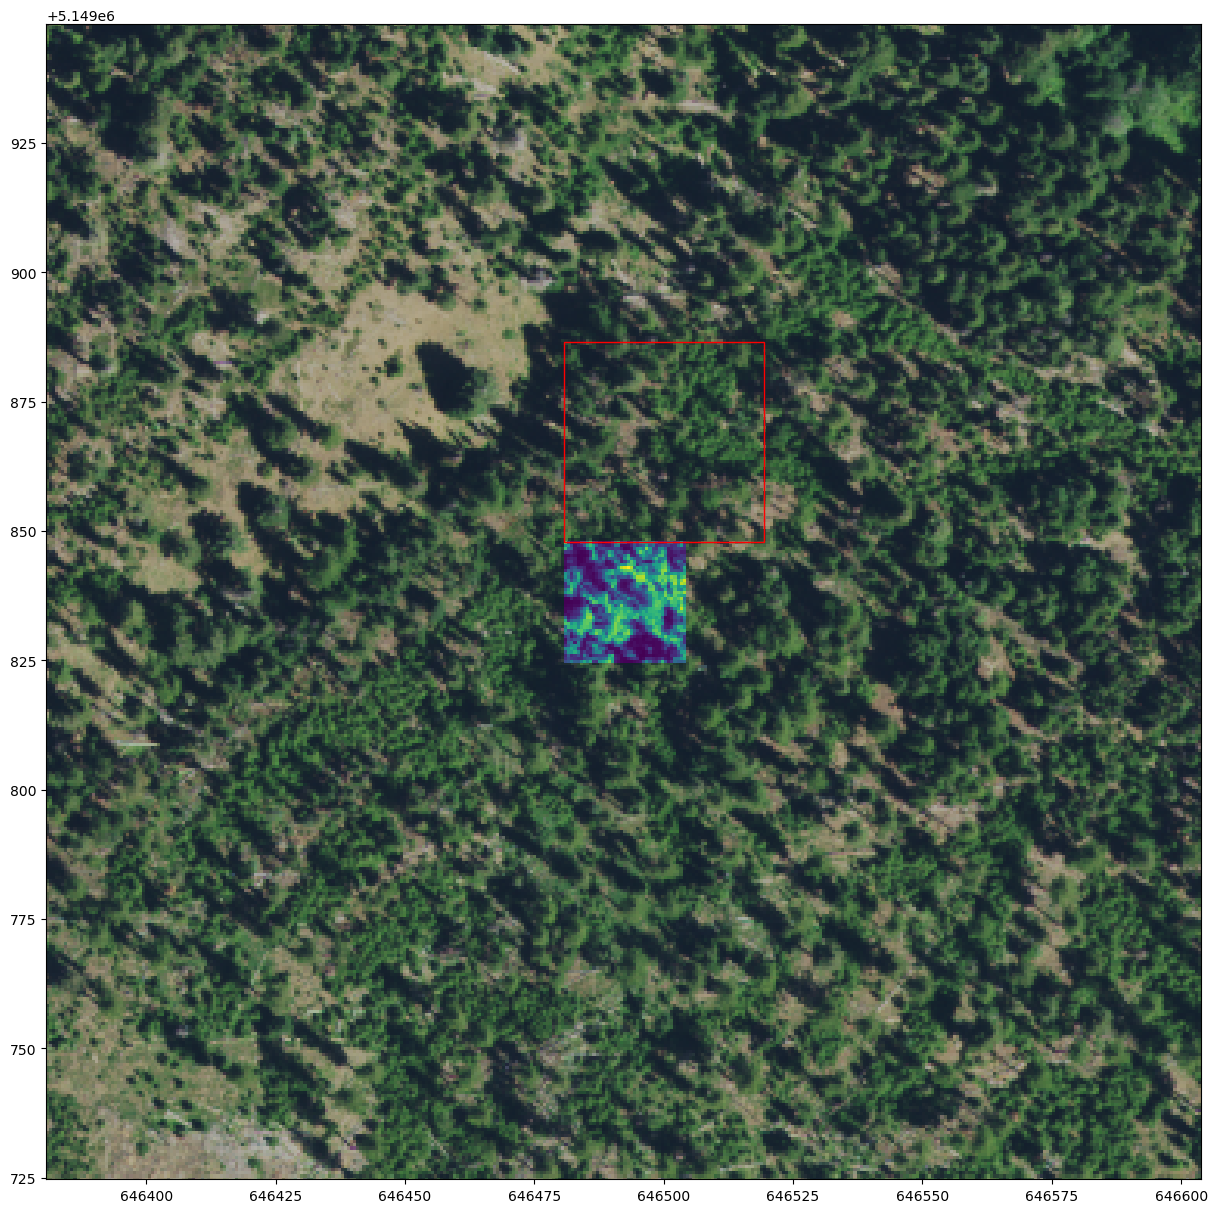

<Axes: >

In [9]:
fig, ax = plt.subplots(1, figsize=(15,15))
plt.axis([xmin - 100, xmax + 100, ymin - 100, ymax + 100])
show(src, ax=ax)
rect = Rectangle((xmin, ymax), window.width, window.height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
show(data[1,:], transform=src_transform)

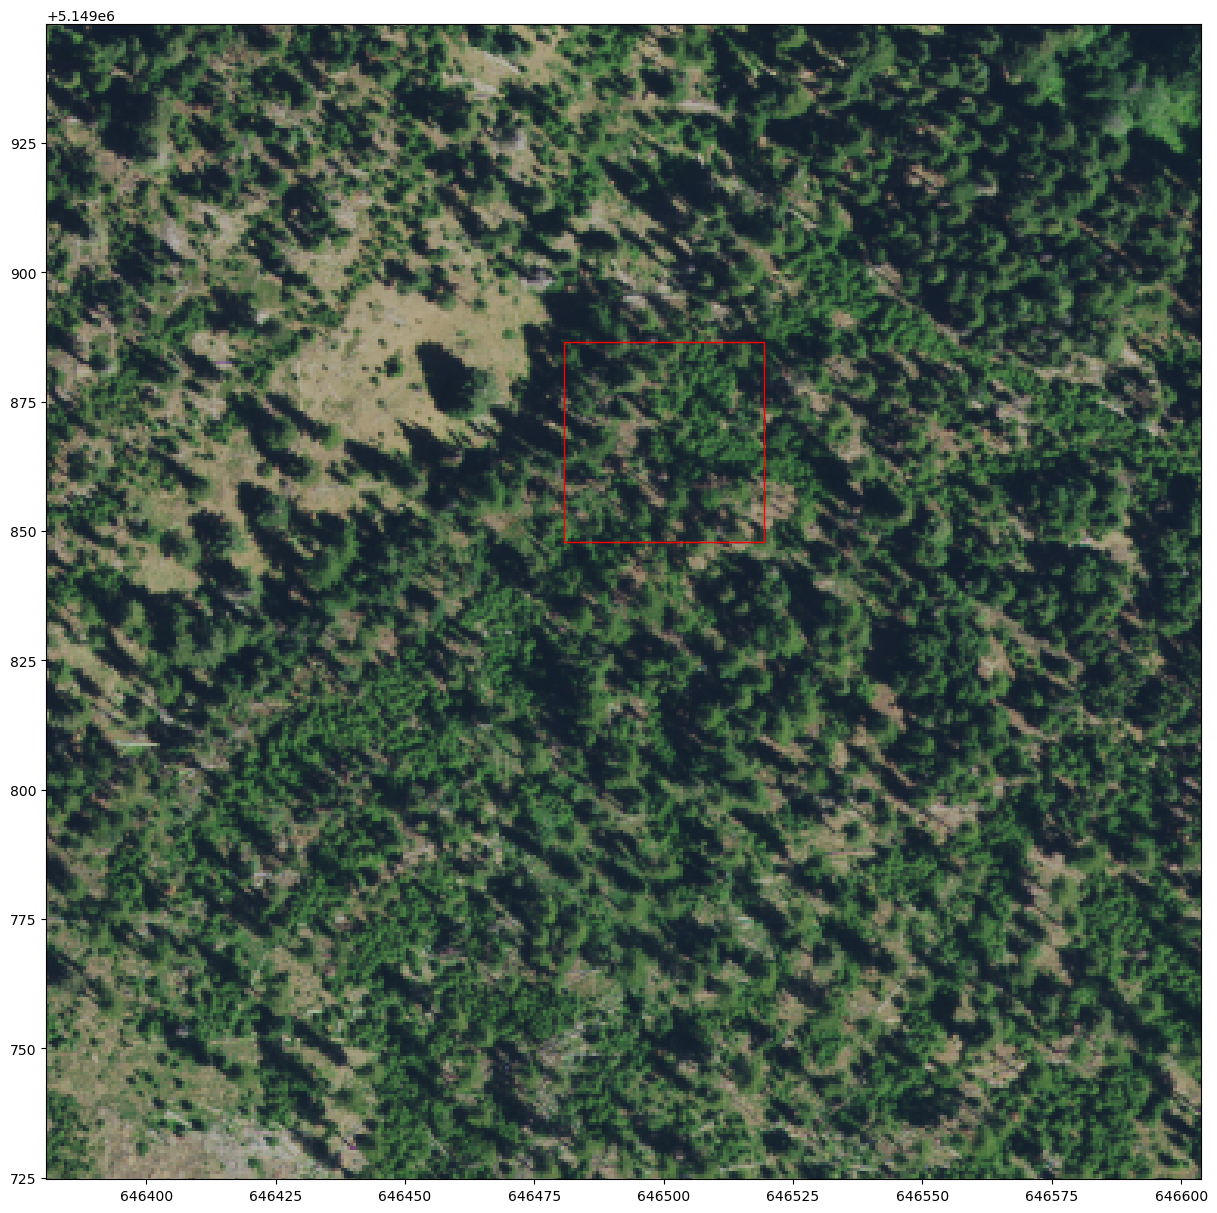

<Axes: >

In [10]:
fig, ax = plt.subplots(1, figsize=(15,15))
plt.axis([xmin - 100, xmax + 100, ymin - 100, ymax + 100])
show(src, ax=ax)
rect = Rectangle((xmin, ymax), window.width, window.height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
show(data[:3,:], transform=src_transform)

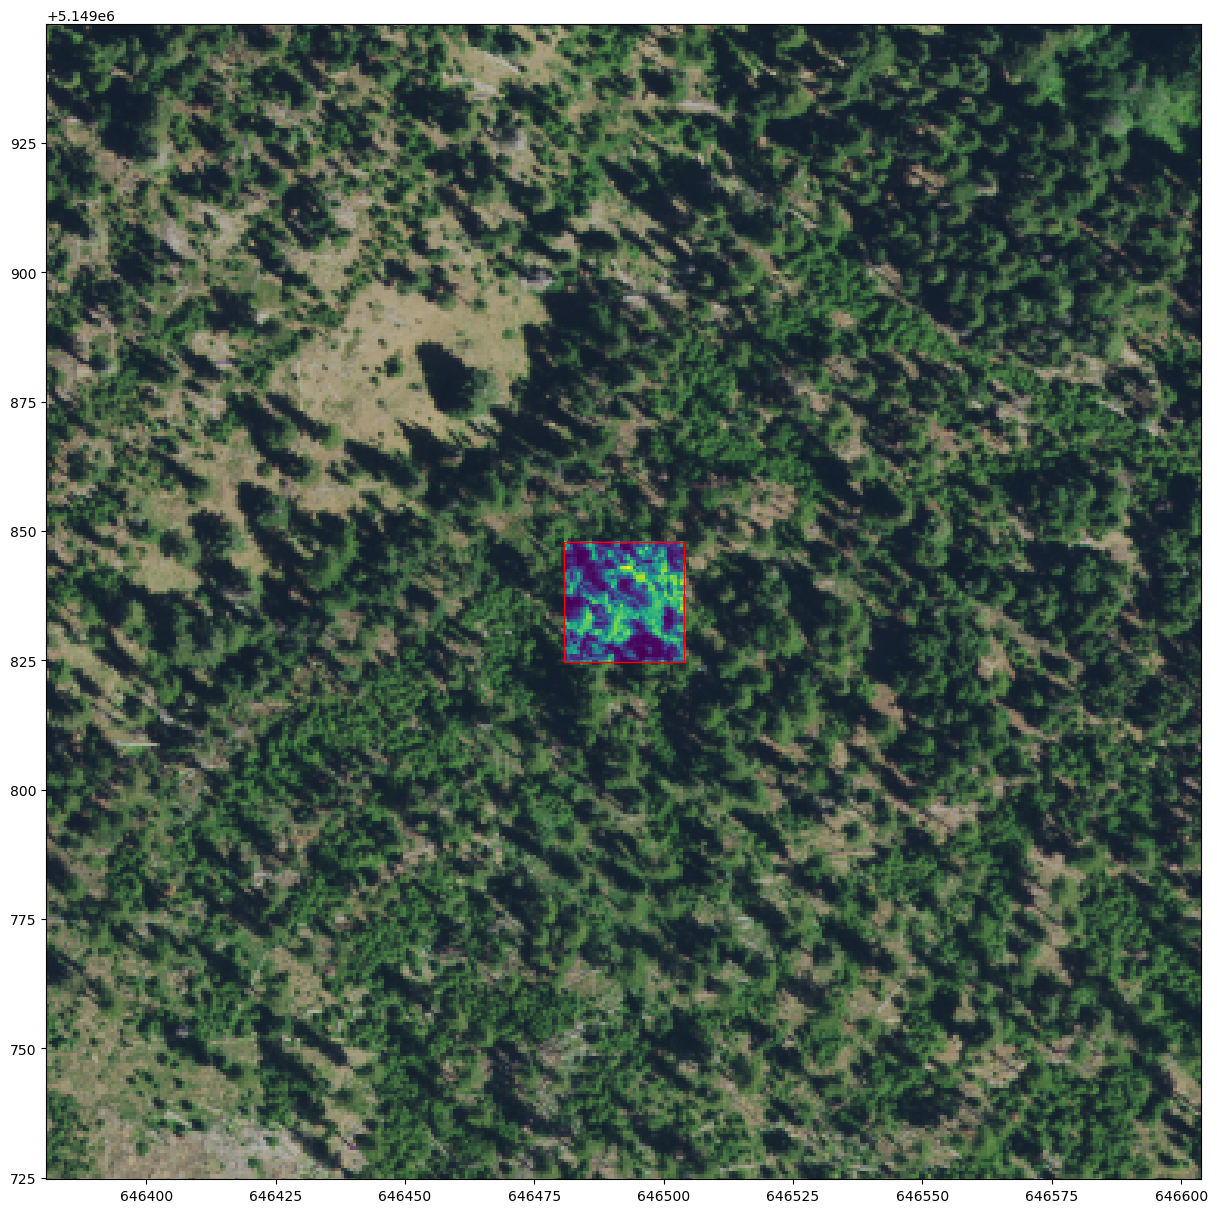

<Axes: >

In [13]:
fig, ax = plt.subplots(1, figsize=(15,15))
plt.axis([xmin - 100, xmax + 100, ymin - 100, ymax + 100])
show(src, ax=ax)
rect = Rectangle((xmin, ymin), window.width*.6, window.height*.6, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
show(data[1,:], transform=src_transform)

In [15]:
row.geometry.bounds

(-121.09147220575916,
 46.486063501877354,
 -121.09117690776094,
 46.48626747293531)

In [16]:
dst_transform

Affine(5.369054513111719e-06, 0.0, -121.09147220575916,
       0.0, -5.367659419912223e-06, 46.48626747293531)

In [17]:
width

55

In [18]:
height

38

In [19]:
def fetch_metadata(filename, bands, res, out_dir='.'):
    """Fetch DEM metadata from the 3Dep web service and write to disk.
        # id
        # resolution
        # properties
        # - bands
        # - datetime start (in seconds)
        # crs
        # transform
        # bounds
        # license for each collection

    :param filename: Name of the metadata file to write.
    :type filename: str
    :param bands: Dictionary of band names and descriptions.
    :type bands: dict
    :param res: Spatial resolution of the DEM.
    :type res: int or float
    :param out_dir: Directory to write the metadata file to, by default '.'.
    :type out_dir: str, optional
    :return: True if metadata file was successfully written to disk.
    :rtype: bool
    """ 
    import requests
    import json
    import calendar
    from datetime import datetime

    month_name = {month: index for index,
                  month in enumerate(calendar.month_name) if month}

    URL = 'https://elevation.nationalmap.gov/arcgis/'\
          'rest/services/3DEPElevation/ImageServer?f=pjson'
    r = requests.get(URL)
    src_metadata = r.json()

    metadata = {}
    for key in src_metadata.keys():
        if key in ['currentVersion', 'description', 'copyrightText']:
            metadata[key] = src_metadata[key]

    m, d, y = src_metadata['copyrightText']\
        .replace(',', '')\
        .replace('.', '')\
        .split(' ')[-3:]
    timestamp = datetime(int(y), month_name[m], int(d)).timestamp()

    _bands = [{'id': key, 'name': bands[key]} for key in bands.keys()]

    metadata.update(
        # id=image_id,
        name=' '.join(src_metadata['copyrightText'].split(' ')[:-3]),
        resolution=res,
        bands=_bands,
        properties={
            'system:time_start': int(timestamp * 1000),
        }
    )

    with open(os.path.join(out_dir, filename), "w") as f:
        f.write(json.dumps(metadata, indent=4))

    return True


def fetch_dems(
    cell_id: str,
    geom: gpd.GeoSeries,
    state: str,
    out_dir: str or Path,
    res:int=10,
    padding:int=1e3,
    overwrite:bool=False,
    progressbar:bool=False
):
    """Fetch DEMs for a given cell_id and geometry.

    :param cell_id: The cell ID of the geometry.
    :type cell_id: str
    :param geom: The geometry to fetch DEMs for.
    :type geom: shapely.geometry.Polygon
    :param state: The state to fetch DEMs for.
    :type state: str
    :param out_dir: The directory to write the DEMs to.
    :type out_dir: str
    :param res: The spatial resolution of the DEMs, by default 10.
    :type res: int or float, optional
    :param padding: The amount of padding to add to the geometry, by default 1e3.
    :type padding: int or float, optional
    :param overwrite: Whether to overwrite existing DEMs, by default False.
    :type overwrite: bool, optional
    :param progressbar: Whether to display a progress bar, by default False.
    :type progressbar: bool, optional
    :return: None
    :rtype: None
    """

    PROFILE = {
        'driver': 'GTiff',
        'interleave': 'band',
        'tiled': True,
        'blockxsize': 256,
        'blockysize': 256,
        'compress': 'lzw',
        'nodata': -9999,
        'dtype': rasterio.float32,
        # 'count': 5 # set number of bands
    }

    itemdir = f'{cell_id}_{state}_3DEP_{res}mDEM'
    filename = f'{itemdir}-cog.tif'
    outfile = out_dir / filename

    if (not os.path.exists(outfile)) or overwrite:
        print_message(f"Processing file {itemdir}")

        # We want to request the data in a planar coordinate system
        # so we can calculate topographic metrics. This is to avoid
        # distortions due to the curvature of the earth.
        # See discussion https://gis.stackexchange.com/q/7906/72937
        p_crs = infer_utm(geom.bounds)
        p_geom = gpd.GeoSeries(geom, crs=4326).to_crs(p_crs)

        if padding > 0:
            p_geom = p_geom.buffer(padding, join_style=2)

        p_bbox = p_geom[0].bounds
        p_width = np.ceil((p_bbox[2]-p_bbox[0])/res).astype(int)
        p_height = np.ceil((p_bbox[-1]-p_bbox[1])/res).astype(int)
        p_trf = transform.from_bounds(*p_bbox, p_width, p_height)  # type: ignore

        # Extend the AOI with a buffer to avoid edge effects
        # when calculating topographic metrics
        buffer_size = int(round((p_width)//2/100))*100
        p_buffer = p_geom.buffer(buffer_size * res, join_style=2)
        bbox_buff = p_buffer.bounds.values[0]

        # Fetch DEM and apply a smoothing filter to mitigate stitching/edge artifacts
        try:
            dem = quad_fetch(bbox=bbox_buff, dim=1, res=res,
                            crs=p_crs.to_epsg(), noData=-9999)
        except Exception as e:
            print_message(f"Failed to fetch {itemdir}. Exception raised: {e}")
            return
        dem = filters.gaussian(dem, 3)

        # We'll need this to transform the data back to the original CRS
        crs = CRS.from_epsg(4326)
        bbox = p_geom.to_crs(crs).bounds.values[0]
        width = np.ceil(degrees_to_meters(bbox[2]-bbox[0])/res)
        height = np.ceil(degrees_to_meters(bbox[-1]-bbox[1])/res)
        trf = transform.from_bounds(*bbox, width, height)  # type: ignore

        # ---
        try:
            bands = [
                dem,
                slope(dem, p_crs, p_trf),
                aspect(dem, p_crs, p_trf),
                flow_accumulation(dem),
                tpi(dem, irad=15, orad=30, res=res),
                tpi(dem, irad=185, orad=200, res=res),
            ]
            bands.append(
                classify_slope_position(bands[3], bands[0])
            )
            bands.append(
                classify_landform(bands[4], bands[3], bands[0])
            )
        except Exception as e:
            print_message(f"Failed to calculate topographic metrics for {itemdir}. Exception raised: {e}")
            return
        
        # Remove buffer
        bands = [center_crop_array((p_height, p_width), x) for x in bands]
        # ---

        band_info = {
            'dem': 'Digital Elevation Model',
            'slope': 'Slope',
            'aspect': 'Aspect',
            'flowacc': 'Flow Accumulation',
            'tpi300': 'Topographic Position Index (300m)',
            'tpi2000': 'Topographic Position Index (2000m)',
            'spc300': 'Slope Position Class (300m)',
            'landform': 'Landform Class',
        }

        # fetch_metadata(itemdir, band_info, res, out_dir / itemdir)

        # Reproject, generate cog, and write the data to disk
        PROFILE.update(crs=crs, transform=trf, width=width,
                       height=height, count=len(bands))
        cog_profile = cog_profiles.get("deflate")

        with MemoryFile() as memfile:
            with memfile.open(**PROFILE) as dst:
                dst_idx = 1
                for band, data in zip(band_info.keys(), bands):
                    output = np.zeros(dst.shape, rasterio.float32)
                    reproject(
                        source=data,
                        destination=output,
                        src_transform=p_trf,
                        src_crs=p_crs,
                        dst_transform=trf,
                        dst_crs=crs,
                        resampling=Resampling.nearest
                    )
                    dst.write(output, dst_idx)
                    dst.set_band_description(dst_idx, band_info[band])

                    # Select band to generate preview
                    if dst_idx == 1:
                        cm = plt.get_cmap('gist_earth')
                        norm_out = cm(output / output.max())[:, :, :3] * 255
                        preview = Image.fromarray(
                            norm_out.astype(np.uint8)).convert('RGB')
                        preview.save(
                            out_dir / filename.replace('-cog.tif', '-preview.png'))

                    dst_idx += 1

                try:
                    fetch_metadata(filename.replace('-cog.tif', '-metadata.json'), band_info, res, out_path)
                except Exception as e:
                    print_message(f"Failed to write metadata for {itemdir}. Exception raised: {e}")
                    return

                cog_translate(
                    dst,
                    outfile,
                    cog_profile,
                    in_memory=True,
                    quiet=True
                )

    else:
        print_message(f"File {itemdir} already exists, skipping...")

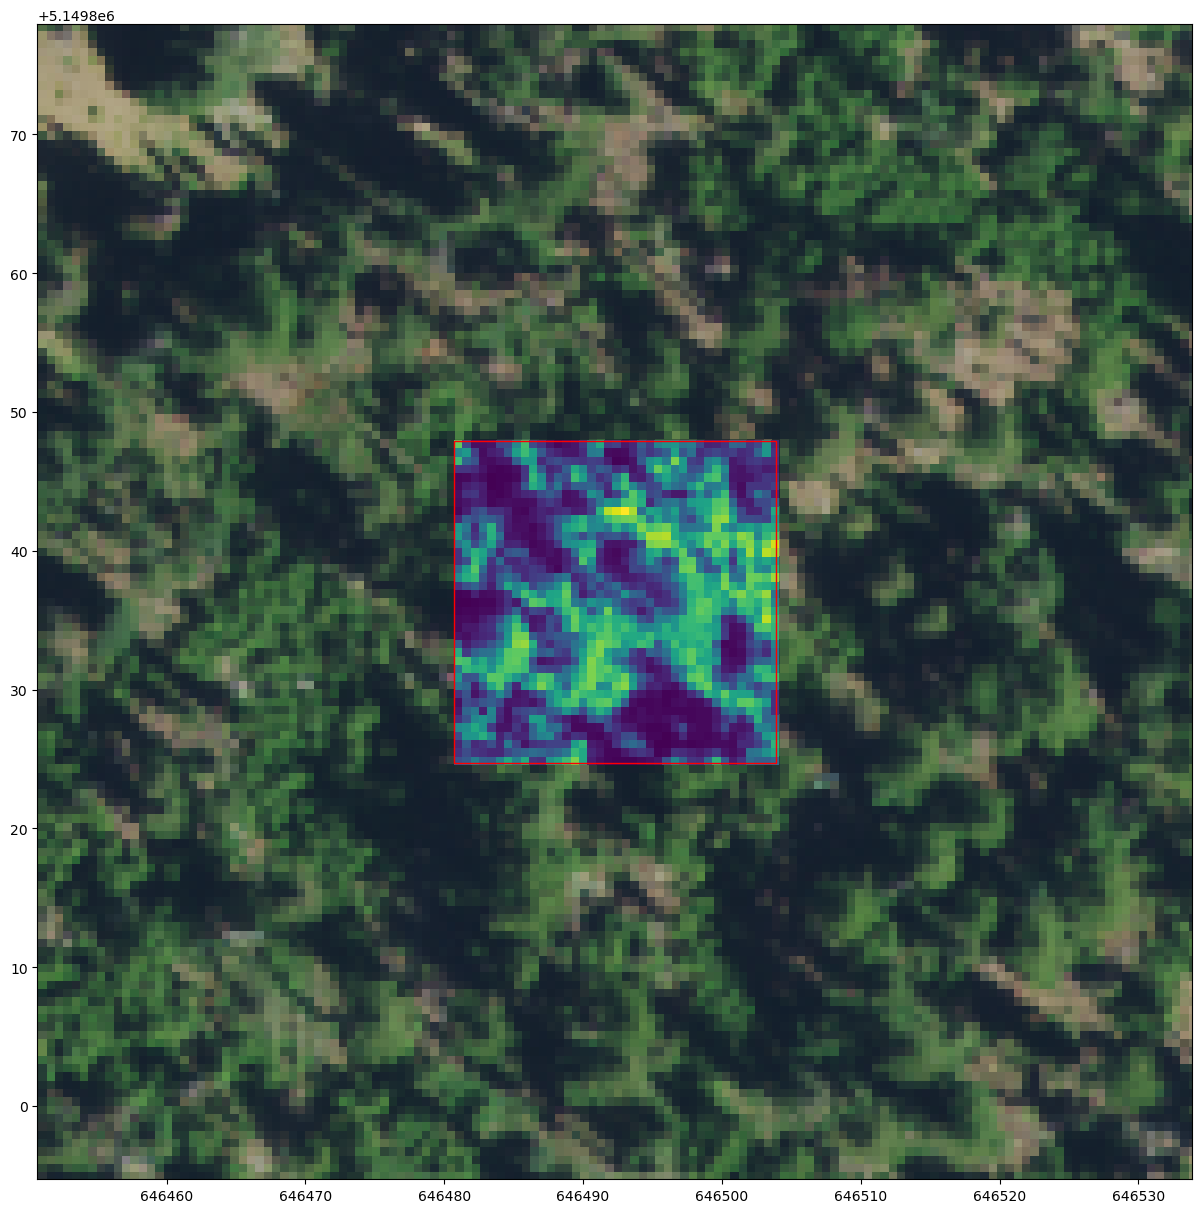

<Axes: >

In [20]:
fig, ax = plt.subplots(1, figsize=(15,15))
plt.axis([xmin - 30, xmax + 30, ymin - 30, ymax + 30])
show(src, ax=ax)
rect = Rectangle((xmin, ymin), window.width*.6, window.height*.6, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
show(data[1,:], transform=src_transform)

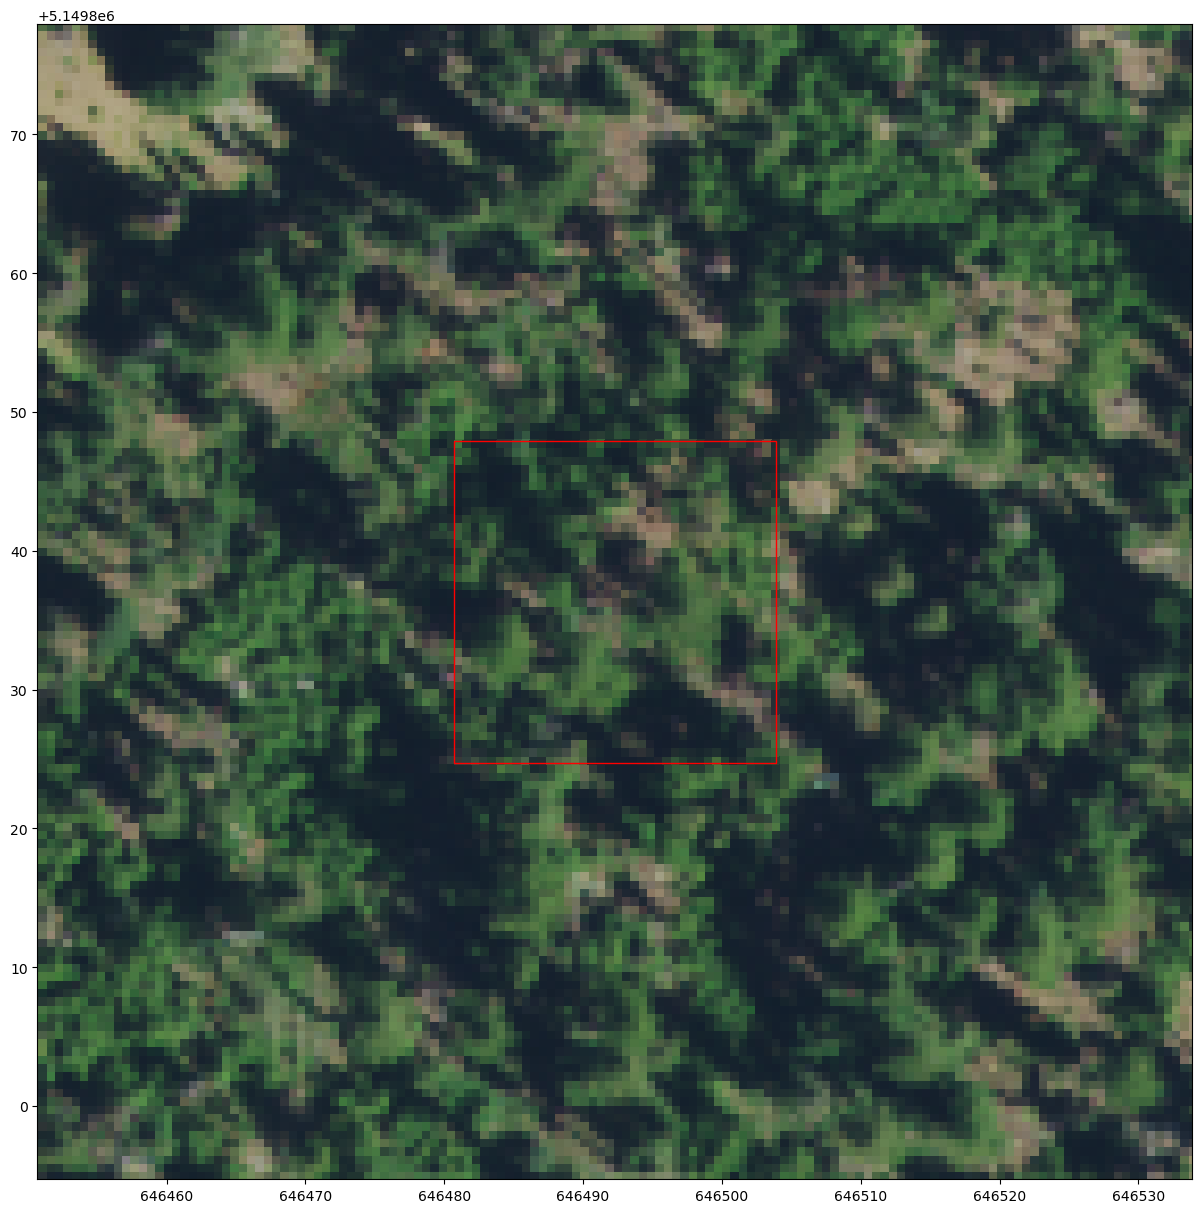

<Axes: >

In [21]:
fig, ax = plt.subplots(1, figsize=(15,15))
plt.axis([xmin - 30, xmax + 30, ymin - 30, ymax + 30])
show(src, ax=ax)
rect = Rectangle((xmin, ymin), window.width*.6, window.height*.6, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
show(data[:3,:], transform=src_transform)